In this Notebook we will attempt to predict the dynamics of the second COVID-19 wave in Belgium at the level of arrondissements, based on ...
- Expectation values of all calibrated parameters except $\beta^R$, $\beta^U$ and $\beta^M$, calibrated on the entire first wave
- Calibrated values of parameters $\beta^R$, $\beta^U$, and $\beta^M$ (and `warmup`), calibrated on the ascending part of the second wave
- Initial condition for all states, based on calibration on first wave.
- Knowledge of the timing and severity of non-pharmaceutical measures in the near future
- Uncertainties in the first-wave parameter values (from previous calibration), and uncertainties in the second-wave parameter values (from new calibration)

**Some side notes (criticism)**
- The expectation values of each parameter do *not* correspond to the same run

In [12]:
# Preamble
import corner
import pandas as pd
import json
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

from covid19model.models import models
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_contact_matrix_function
from covid19model.models.utils import initial_state
# from covid19model.optimization.run_optimization import checkplots, calculate_R0
# from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
# from covid19model.optimization import pso, objective_fcns
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot, plot_fit, plot_calibration_fit
from covid19model.visualization.utils import moving_avg
from covid19model.optimization.utils import perturbate_PSO, run_MCMC
from covid19model.optimization.utils import samples_dict_to_emcee_chain # used for corner plots
import random
import datetime

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Copied from mrollier-calibration-WAVE2_spatial.ipynb
import gc
import sys, getopt
import os
import ujson as json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

from covid19model.models import models
from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.optimization import pso, objective_fcns
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot
from covid19model.models.utils import initial_state

spatial='arr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Time the runtime
initial_time = datetime.datetime.now()

# Choose to show progress bar. This cannot be shown on HPC
progress = True

# User-defined initial states json file
initial_states_date = '2020-08-27'
initial_states_loc = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr'
initial_states_json = f'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-02_states_{initial_states_date}.json'

In [14]:
backend = None # None or True
job = 'R0' # R0 or FULL
warmup = None # warmup must be defined if job == FULL 
maxiter_PSO = 50 # defaults is 50 (which isn't much)
maxn_MCMC = 100 # default is 100 (which isn't much)
signature = 'predict-wave2-from-wave1'
agg = spatial

# Date at which script is started
run_date = str(datetime.date.today())

In [16]:
# ---------
# Load data
# ---------

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)
G, N = initN.shape
# Sciensano spatially stratified data
moving_avg=False
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values='hospitalised_IN', moving_avg=moving_avg)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)

In [18]:
# ------------------------
# Define results locations
# ------------------------

# Path where traceplot and autocorrelation figures should be stored.
# This directory is split up further into autocorrelation, traceplots
fig_path = f'../../results/calibrations/COVID19_SEIRD/{agg}/'
# Path where MCMC samples should be saved
samples_path = f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}/'
# Path where samples backend should be stored
backend_folder = f'../../results/calibrations/COVID19_SEIRD/{agg}/backends/'

# Verify that these paths exists
if not (os.path.exists(fig_path) and os.path.exists(samples_path) and os.path.exists(backend_folder)):
    raise Exception("Some of the results location directories do not exist.")

# Verify that the fig_path subdirectories used in the code exist
if not (os.path.exists(fig_path+"autocorrelation/") and os.path.exists(fig_path+"traceplots/") \
       and os.path.exists(fig_path+"pso/")):
    raise Exception(f"The directory {fig_path} should have subdirectories 'autocorrelation', 'traceplots' and 'pso'.")

In [19]:
# -----------------------
# Define helper functions
# -----------------------

from covid19model.optimization.utils import assign_PSO, plot_PSO, perturbate_PSO, run_MCMC

In [20]:
# ------------------------------------------------------
# Define time-dependant parameter functions from classes
# ------------------------------------------------------

# Load both classes
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, make_mobility_update_function

### ATTENTION ###

# Define contact matrix functions based on 4 prevention parameters (effectivity parameters)
policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_full_relaxation # with delayed-ramp function

# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

In [21]:
# ---------------------
# Load model parameters ... from WAVE1 data (taken from corner plots)
# ---------------------

### ATTENTION ###

# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
# Copy best-fit values from MR-postprocessing-calibration.ipynb
params.update({'l' : 8.23,
               'prev_schools': 1.0, # was not calibrated because schools were closed all the time
               'prev_work': 0.651,
               'prev_rest': 0.00786,
               'prev_home' : 0.446,
               'relaxdate' : '2021-07-01', # new parameter, only relevant for 2021
               'l_relax' : 31 # new parameter, only relevant for 2021
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params.update({'default_mobility' : None})

In [24]:
# --------------------
# Model initialisation
# --------------------

# Model initial condition on September 1st
# This contains a dict with all states, and values for these states per age
# This needs to be modified in such a way that we have the output per region as well
with open(f'{initial_states_loc}/{initial_states_json}', 'r') as fp:
    initial_states = json.load(fp) 

# Initiate model with initial states, defined parameters, and proper time dependent functions
model = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : policies_WAVE2_full_relaxation, 'place' : mobility_wrapper_function}, spatial=agg)

Let's say the government is getting worried again early September, and gathers data until October, which is when a decision is to be made on how to act.


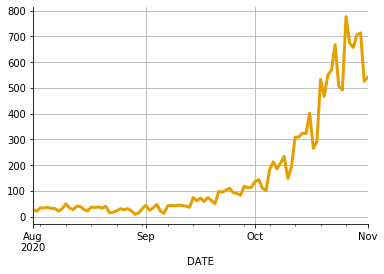

In [38]:
# Check the time series data and decide on a natural reference point, e.g. one full month of data
df_sciensano.sum(axis=1)['2020-08-01':'2020-11-01'].plot()

print("Let's say the government is getting worried again early September, and gathers data until October, which is when a decision is to be made on how to act.")

In [43]:
# ------------------
# Calibration set-up
# ------------------

# Start data of recalibration ramp
start_calibration = '2020-09-01'
# Last datapoint used to calibrate warmup and beta
end_calibration = '2020-10-01' # date of lockdown

# Spatial unit: depends on aggregation
spatial_unit = f'{agg}_WAVE2-{job}_{signature}'

# PSO settings
processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()))
sys.stdout.flush()
multiplier = 10
maxiter = maxiter_PSO
popsize = multiplier*processes

# MCMC settings
max_n = maxn_MCMC
print_n = 100

# Offset needed to deal with zeros in data in a Poisson distribution-based calibration
poisson_offset = 1

In [40]:
# -------------------------
# Print statement to stdout
# -------------------------

print('\n------------------------------------------')
print('PERFORMING CALIBRATION OF WARMUP and BETAs')
print('------------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')
sys.stdout.flush()


------------------------------------------
PERFORMING CALIBRATION OF WARMUP and BETAs
------------------------------------------

Using data from 2020-09-01 until 2020-10-01

1) Particle swarm optimization
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Using 12 cores for a population of 120, for maximally 50 iterations.



In [42]:
# --------------
# define dataset
# --------------

# Only use hospitalisation data
data=[df_sciensano[start_calibration:end_calibration]]
states = ["H_in"]
weights = [1]

In [ ]:
# -----------
# Perform PSO
# -----------

# set optimisation settings
# NOTE: the initial states are from August 27th, so the warmup time should be the number of days
# between August 27th and September 1st, i.e. 5.
pars = ['warmup','beta_R', 'beta_U', 'beta_M']
bounds=((0.0,10.0),(0.010,0.060), (0.010,0.060), (0.010,0.060))
# run optimisation
theta = pso.fit_pso(model, data, pars, states, bounds, weights=weights, maxiter=maxiter, popsize=popsize, dist='poisson',
                    poisson_offset=poisson_offset, agg=agg, start_date=start_calibration, processes=processes)
# Fill in line below if you want to skip PSO
# theta = np.array([48, 0.01896, 0.02153, 0.02599])
# Assign estimate.
warmup, pars_PSO = assign_PSO(model.parameters, pars, theta)
model.parameters = pars_PSO

# Perform simulation with best-fit results
out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

# Print statement to stdout once
print(f'\nPSO RESULTS:')
print(f'------------')
print(f'warmup: {warmup}')
print(f'infectivities {pars[1:]}: {theta[1:]}.')
sys.stdout.flush()